# Visual Classification experiments

## Overview
Experiments based on works in:
- Visual Classification via Description, Menon et al. 2022
- Waffling around for Performance, Roth et al. 2023

In [1]:
import json
from load import *
import torchmetrics
from tqdm import tqdm
import torch

/home/luke/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Creating descriptors...
Example description for class 'Black-footed Albatross': "Black-footed Albatross, which is a seabird"

Creating descriptor frequencies...


RuntimeError: Failed to import transformers.models.auto because of the following error (look up to see its traceback):
libssl.so.1.1: cannot open shared object file: No such file or directory

In [ ]:
def load_or_initialize_results(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        return {}
    
def save_results(results, file_path):
    with open(file_path, 'w') as file:
        json.dump(results, file, indent=4)

results_file_path = 'results/experiment_results.json'
results = load_or_initialize_results(results_file_path)

In [ ]:

# Initialize the environment
seed_everything(hparams['seed'])

# Prepare the data loader
bs = hparams['batch_size']
dataloader = DataLoader(dataset, bs, shuffle=False, num_workers=16, pin_memory=True)  # Shuffle should be False for class-wise evaluation

# Load the model and preprocessing
print("Loading model...")
device = torch.device(hparams['device'])
model, preprocess = clip.load(hparams['model_size'], device=device, jit=False)
model.eval()
model.requires_grad_(False)

# Encode descriptions and labels
print("Encoding descriptions...")
description_encodings = compute_description_encodings(model)
label_encodings = compute_label_encodings(model)

Loading model...
Encoding descriptions...


In [ ]:

# Number of classes
num_classes = len(dataset.classes)

# Evaluation metrics for overall and per-class accuracies
print("Evaluating...")
overall_lang_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
overall_lang_accuracy_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=5).to(device)

overall_clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
overall_clip_accuracy_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=5).to(device)

# Initialize dictionaries to track class-wise accuracy
class_wise_lang_accuracy = {i: torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device) for i in range(num_classes)}
class_wise_clip_accuracy = {i: torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device) for i in range(num_classes)}

Evaluating...


In [ ]:

for batch_number, (images, labels) in enumerate(tqdm(dataloader)):    
    images = images.to(device)
    labels = labels.to(device)
    
    # Encode images
    image_encodings = model.encode_image(images)
    image_encodings = F.normalize(image_encodings)
    
    # Compute similarities and make predictions
    image_labels_similarity = image_encodings @ label_encodings.T
    clip_predictions = image_labels_similarity.argmax(dim=1)
    
    # Update overall and class-wise accuracies for CLIP
    overall_clip_accuracy_metric(image_labels_similarity, labels)
    overall_clip_accuracy_metric_top5(image_labels_similarity, labels)
    for i in range(num_classes):
        class_mask = labels == i
        if class_mask.any():
            class_wise_clip_accuracy[i](clip_predictions[class_mask], labels[class_mask])

    # Compute description-based predictions
    image_description_similarity = [None]*n_classes
    image_description_similarity_cumulative = [None]*n_classes

    for i, (k, v) in enumerate(description_encodings.items()):
        dot_product_matrix = image_encodings @ v.T
        
        if frequency_penalty_config:
            for descriptor in gpt_descriptions[k]:
                freq = descriptors_freq[freq_type].get(descriptor, 1)
                norm_freq = freq / max(descriptors_freq[freq_type].values())
                penalty_index = gpt_descriptions[k].index(descriptor)
                dot_product_matrix[:, penalty_index] /= norm_freq

        if similarity_penalty_config:
            class_average_sim = average_cosine_similarities.get(k, 0)  # Default to 0 if not found
            dot_product_matrix -= class_average_sim
        
        image_description_similarity[i] = dot_product_matrix
        image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])

    cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)
    descr_predictions = cumulative_tensor.argmax(dim=1)
    
    # Update overall and class-wise accuracies for descriptions
    overall_lang_accuracy_metric(cumulative_tensor.softmax(dim=-1), labels)
    overall_lang_accuracy_metric_top5(cumulative_tensor.softmax(dim=-1), labels)
    for i in range(num_classes):
        class_mask = labels == i
        if class_mask.any():
            class_wise_lang_accuracy[i](descr_predictions[class_mask], labels[class_mask])

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


In [ ]:

# Print class-wise accuracies
print("\nClass-wise Description-based Accuracy:")
for i, acc in class_wise_lang_accuracy.items():
    class_name = dataset.classes[i]
    accuracy = 100 * acc.compute().item()
    print(f"Desc. Acc.: {accuracy:.3f}% - {class_name}")

print("\nClass-wise CLIP-Standard Accuracy:")
for i, acc in class_wise_clip_accuracy.items():
    class_name = dataset.classes[i]
    accuracy = 100 * acc.compute().item()
    print(f"CLIP Acc.: {accuracy:.3f}% - {class_name}")


Class-wise Description-based Accuracy:
Desc. Acc.: 83.333% - 001.Black_footed_Albatross
Desc. Acc.: 60.000% - 002.Laysan_Albatross
Desc. Acc.: 25.000% - 003.Sooty_Albatross
Desc. Acc.: 60.000% - 004.Groove_billed_Ani
Desc. Acc.: 50.000% - 005.Crested_Auklet
Desc. Acc.: 27.273% - 006.Least_Auklet
Desc. Acc.: 21.739% - 007.Parakeet_Auklet
Desc. Acc.: 27.778% - 008.Rhinoceros_Auklet
Desc. Acc.: 17.241% - 009.Brewer_Blackbird
Desc. Acc.: 83.333% - 010.Red_winged_Blackbird
Desc. Acc.: 46.667% - 011.Rusty_Blackbird
Desc. Acc.: 96.154% - 012.Yellow_headed_Blackbird
Desc. Acc.: 80.000% - 013.Bobolink
Desc. Acc.: 73.333% - 014.Indigo_Bunting
Desc. Acc.: 85.714% - 015.Lazuli_Bunting
Desc. Acc.: 92.857% - 016.Painted_Bunting
Desc. Acc.: 74.074% - 017.Cardinal
Desc. Acc.: 33.333% - 018.Spotted_Catbird
Desc. Acc.: 75.862% - 019.Gray_Catbird
Desc. Acc.: 13.793% - 020.Yellow_breasted_Chat
Desc. Acc.: 86.667% - 021.Eastern_Towhee
Desc. Acc.: 0.000% - 022.Chuck_will_Widow
Desc. Acc.: 27.586% - 023.Bra

In [ ]:
acc_list = []
trivial_count = 0
print("Compare accuracies of description and CLIP-Standard")
for i, acc_class_wise in class_wise_lang_accuracy.items():
    for j, acc_clip_class_wise in class_wise_clip_accuracy.items():
        if i == j:
            class_name = dataset.classes[i]
            acc = acc_class_wise.compute().item() - acc_clip_class_wise.compute().item()
            acc_list.append(acc)
            if acc > 0.001 or acc < -0.001:
                print(f"Desc. Acc. - CLIP Acc.: {acc:.3f}% - {class_name}")
            else:
                trivial_count += 1
                print(f"Desc. Acc. - CLIP Acc.: Trivial - {class_name}")
print("Trivial count: ", trivial_count)

for i in range(len(sorted(acc_list))):
    print(f"{sorted(acc_list)[i]}")
print(sum(acc_list))

Compare accuracies of description and CLIP-Standard
Desc. Acc. - CLIP Acc.: -0.033% - 001.Black_footed_Albatross
Desc. Acc. - CLIP Acc.: -0.133% - 002.Laysan_Albatross
Desc. Acc. - CLIP Acc.: -0.071% - 003.Sooty_Albatross
Desc. Acc. - CLIP Acc.: 0.033% - 004.Groove_billed_Ani
Desc. Acc. - CLIP Acc.: 0.286% - 005.Crested_Auklet
Desc. Acc. - CLIP Acc.: -0.273% - 006.Least_Auklet
Desc. Acc. - CLIP Acc.: 0.174% - 007.Parakeet_Auklet
Desc. Acc. - CLIP Acc.: -0.222% - 008.Rhinoceros_Auklet
Desc. Acc. - CLIP Acc.: 0.138% - 009.Brewer_Blackbird
Desc. Acc. - CLIP Acc.: -0.033% - 010.Red_winged_Blackbird
Desc. Acc. - CLIP Acc.: -0.100% - 011.Rusty_Blackbird
Desc. Acc. - CLIP Acc.: Trivial - 012.Yellow_headed_Blackbird
Desc. Acc. - CLIP Acc.: -0.067% - 013.Bobolink
Desc. Acc. - CLIP Acc.: -0.067% - 014.Indigo_Bunting
Desc. Acc. - CLIP Acc.: 0.071% - 015.Lazuli_Bunting
Desc. Acc. - CLIP Acc.: Trivial - 016.Painted_Bunting
Desc. Acc. - CLIP Acc.: 0.185% - 017.Cardinal
Desc. Acc. - CLIP Acc.: 0.200%

In [ ]:
class_wise_accuracies = {}
differences = {}
for i in range(num_classes):
    class_name = dataset.classes[i]
    desc_accuracy = 100 * class_wise_lang_accuracy[i].compute().item()
    clip_accuracy = 100 * class_wise_clip_accuracy[i].compute().item()
    
    # Calculate the difference between description-based and CLIP-standard accuracies
    difference = desc_accuracy - clip_accuracy
    
    # Store accuracies and their difference in the dictionary
    class_wise_accuracies[class_name] = {
        "Description-based Accuracy": desc_accuracy,
        "CLIP-Standard Accuracy": clip_accuracy,
        "Difference": difference
    }
    
    # Also store the difference separately for sorting
    differences[class_name] = difference

# Sort classes by the magnitude of difference
sorted_classes_by_difference = sorted(differences, key=differences.get, reverse=True)

# Reorganize the class-wise accuracies based on the sorted order
sorted_class_wise_accuracies = {class_name: class_wise_accuracies[class_name] for class_name in sorted_classes_by_difference}

# Structure the experimental results
experimental_results = {}
experimental_results["Class-wise Accuracies and Differences (Top 5)"] = [list(sorted_class_wise_accuracies.keys())[:5]]
experimental_results["Class-wise Accuracies and Differences (Bottom 5)"] = [list(sorted_class_wise_accuracies.keys())[-5:]]
experimental_results["Trivial Count"] = trivial_count
experimental_results["Class-wise Accuracies and Differences"] = sorted_class_wise_accuracies
experimental_results["Total Description-based Top-1 Accuracy: "] = 100*overall_lang_accuracy_metric.compute().item()
experimental_results["Total Description-based Top-5 Accuracy: "] = 100*overall_lang_accuracy_metric_top5.compute().item()
experimental_results["Total CLIP-Standard Top-1 Accuracy: "] = 100*overall_clip_accuracy_metric.compute().item()
experimental_results["Total CLIP-Standard Top-5 Accuracy: "] = 100*overall_clip_accuracy_metric_top5.compute().item()

print(experimental_results["Class-wise Accuracies and Differences"])

{'091.Mockingbird': {'Description-based Accuracy': 60.00000238418579, 'CLIP-Standard Accuracy': 6.666667014360428, 'Difference': 53.33333536982536}, '077.Tropical_Kingbird': {'Description-based Accuracy': 86.66666746139526, 'CLIP-Standard Accuracy': 46.666666865348816, 'Difference': 40.00000059604645}, '145.Elegant_Tern': {'Description-based Accuracy': 46.666666865348816, 'CLIP-Standard Accuracy': 13.333334028720856, 'Difference': 33.33333283662796}, '092.Nighthawk': {'Description-based Accuracy': 30.000001192092896, 'CLIP-Standard Accuracy': 0.0, 'Difference': 30.000001192092896}, '005.Crested_Auklet': {'Description-based Accuracy': 50.0, 'CLIP-Standard Accuracy': 21.42857164144516, 'Difference': 28.57142835855484}, '027.Shiny_Cowbird': {'Description-based Accuracy': 30.000001192092896, 'CLIP-Standard Accuracy': 6.666667014360428, 'Difference': 23.333334177732468}, '128.Seaside_Sparrow': {'Description-based Accuracy': 40.00000059604645, 'CLIP-Standard Accuracy': 16.66666716337204, 'Di

In [ ]:
# Ensure the structure 'model_size' > 'dataset' > 'freq_type'
model_size = hparams['model_size']
dataset_name = hparams['dataset_name']

if model_size not in results:
    results[model_size] = {}

if dataset_name not in results[model_size]:
    results[model_size][dataset_name] = {}

if freq_type not in results[model_size][dataset_name]:
    results[model_size][dataset_name][freq_type] = {}

# Store results
results[model_size][dataset_name][freq_type] = experimental_results

# Save the updated results
save_results(results, results_file_path)

### Print all relevant results

In [ ]:
print("\nDataset being tested: ", hparams['dataset'], "|| Frequency Penalisation Type: ", freq_type, "|| Similarity Penalisation Applied: ", similarity_penalty_config)
print("Total Description-based Top-1 Accuracy: ", 100 * overall_lang_accuracy_metric.compute().item(), "%")
print("Total Description-based Top-5 Accuracy: ", 100 * overall_lang_accuracy_metric_top5.compute().item(), "%")
print("Total CLIP-Standard Top-1 Accuracy: ", 100 * overall_clip_accuracy_metric.compute().item(), "%")
print("Total CLIP-Standard Top-5 Accuracy: ", 100 * overall_clip_accuracy_metric_top5.compute().item(), "%")
print("Class-wise Accuracies and Differences (Top 5 and Bottom 5):\n", list(sorted_class_wise_accuracies.keys())[:5], "\n", list(sorted_class_wise_accuracies.keys())[-5:])


Dataset being tested:  cub || Frequency Penalisation Type:  None || Similarity Penalisation Applied:  False
Total Description-based Top-1 Accuracy:  53.05488705635071 %
Total Description-based Top-5 Accuracy:  84.13876295089722 %
Total CLIP-Standard Top-1 Accuracy:  52.00207233428955 %
Total CLIP-Standard Top-5 Accuracy:  82.53365755081177 %
Class-wise Accuracies and Differences (Top 5 and Bottom 5):
 ['091.Mockingbird', '077.Tropical_Kingbird', '145.Elegant_Tern', '092.Nighthawk', '005.Crested_Auklet'] 
 ['008.Rhinoceros_Auklet', '095.Baltimore_Oriole', '026.Bronzed_Cowbird', '006.Least_Auklet', '143.Caspian_Tern']


#### Create list of top 5 and bottom 5 results

In [ ]:
classes_top5 = list(sorted_class_wise_accuracies.keys())[:5]
classes_bottom5 = list(sorted_class_wise_accuracies.keys())[-5:]
exceptional_classes = classes_top5 + classes_bottom5

for i in range(len(exceptional_classes)):
    exceptional_classes[i] = exceptional_classes[i].replace("_"," ").split(".")[1:]

exceptional_classes = [x[0] for x in exceptional_classes]

print("Exceptional classes: ", exceptional_classes)

Exceptional classes:  ['Mockingbird', 'Tropical Kingbird', 'Elegant Tern', 'Nighthawk', 'Crested Auklet', 'Rhinoceros Auklet', 'Baltimore Oriole', 'Bronzed Cowbird', 'Least Auklet', 'Caspian Tern']


### Visualise Distributions
Visualise distributions of cosine similarities between class labels and all possible descriptions.

In [ ]:
# class_stats = load_json("class_analysis/class_analysis_cub.json")
# exp_results = load_json("results/experiment_results.json")

# classwise_stats = class_stats["Class-wise Accuracies and Differences"]

# i = 0
# for class_name in classwise_stats:
#     if class_name.replace("_"," ").split(".")[1:] in exp_results["ViT-B/32"]["CUB"]["null"]:
#         i += 1

# print("Number of classes in both class analysis and experiment results: ", i)

[0.6751598119735718, 0.8007080554962158, 0.624618411064148, 0.627627968788147, 0.5707952976226807, 0.5838061571121216, 0.5758252739906311, 0.6900492906570435, 0.7628965973854065, 0.6665796041488647, 0.7397819757461548, 0.5809800028800964, 0.7201846241950989, 0.45294222235679626, 0.6588491797447205, 0.6202618479728699, 0.5066831111907959, 0.5331073999404907, 0.6355856657028198, 0.6097755432128906, 0.4965741038322449, 0.5821142792701721, 0.5113497376441956, 0.7769818305969238, 0.6016516089439392, 0.5913544297218323, 0.6482266187667847, 0.6718083620071411, 0.5542088747024536, 0.7323349118232727, 0.7107782959938049, 0.5924848914146423, 0.7587070465087891, 0.5796810984611511, 0.6160532236099243, 0.5177025198936462, 0.5557200312614441, 0.7659379839897156, 0.5467374324798584, 0.43900027871131897, 0.5061688423156738, 0.8309841156005859, 0.5586580038070679, 0.4884240925312042, 0.540854275226593, 0.6062383651733398, 0.531388521194458, 0.5556440353393555, 0.7801877856254578, 0.562420129776001, 0.

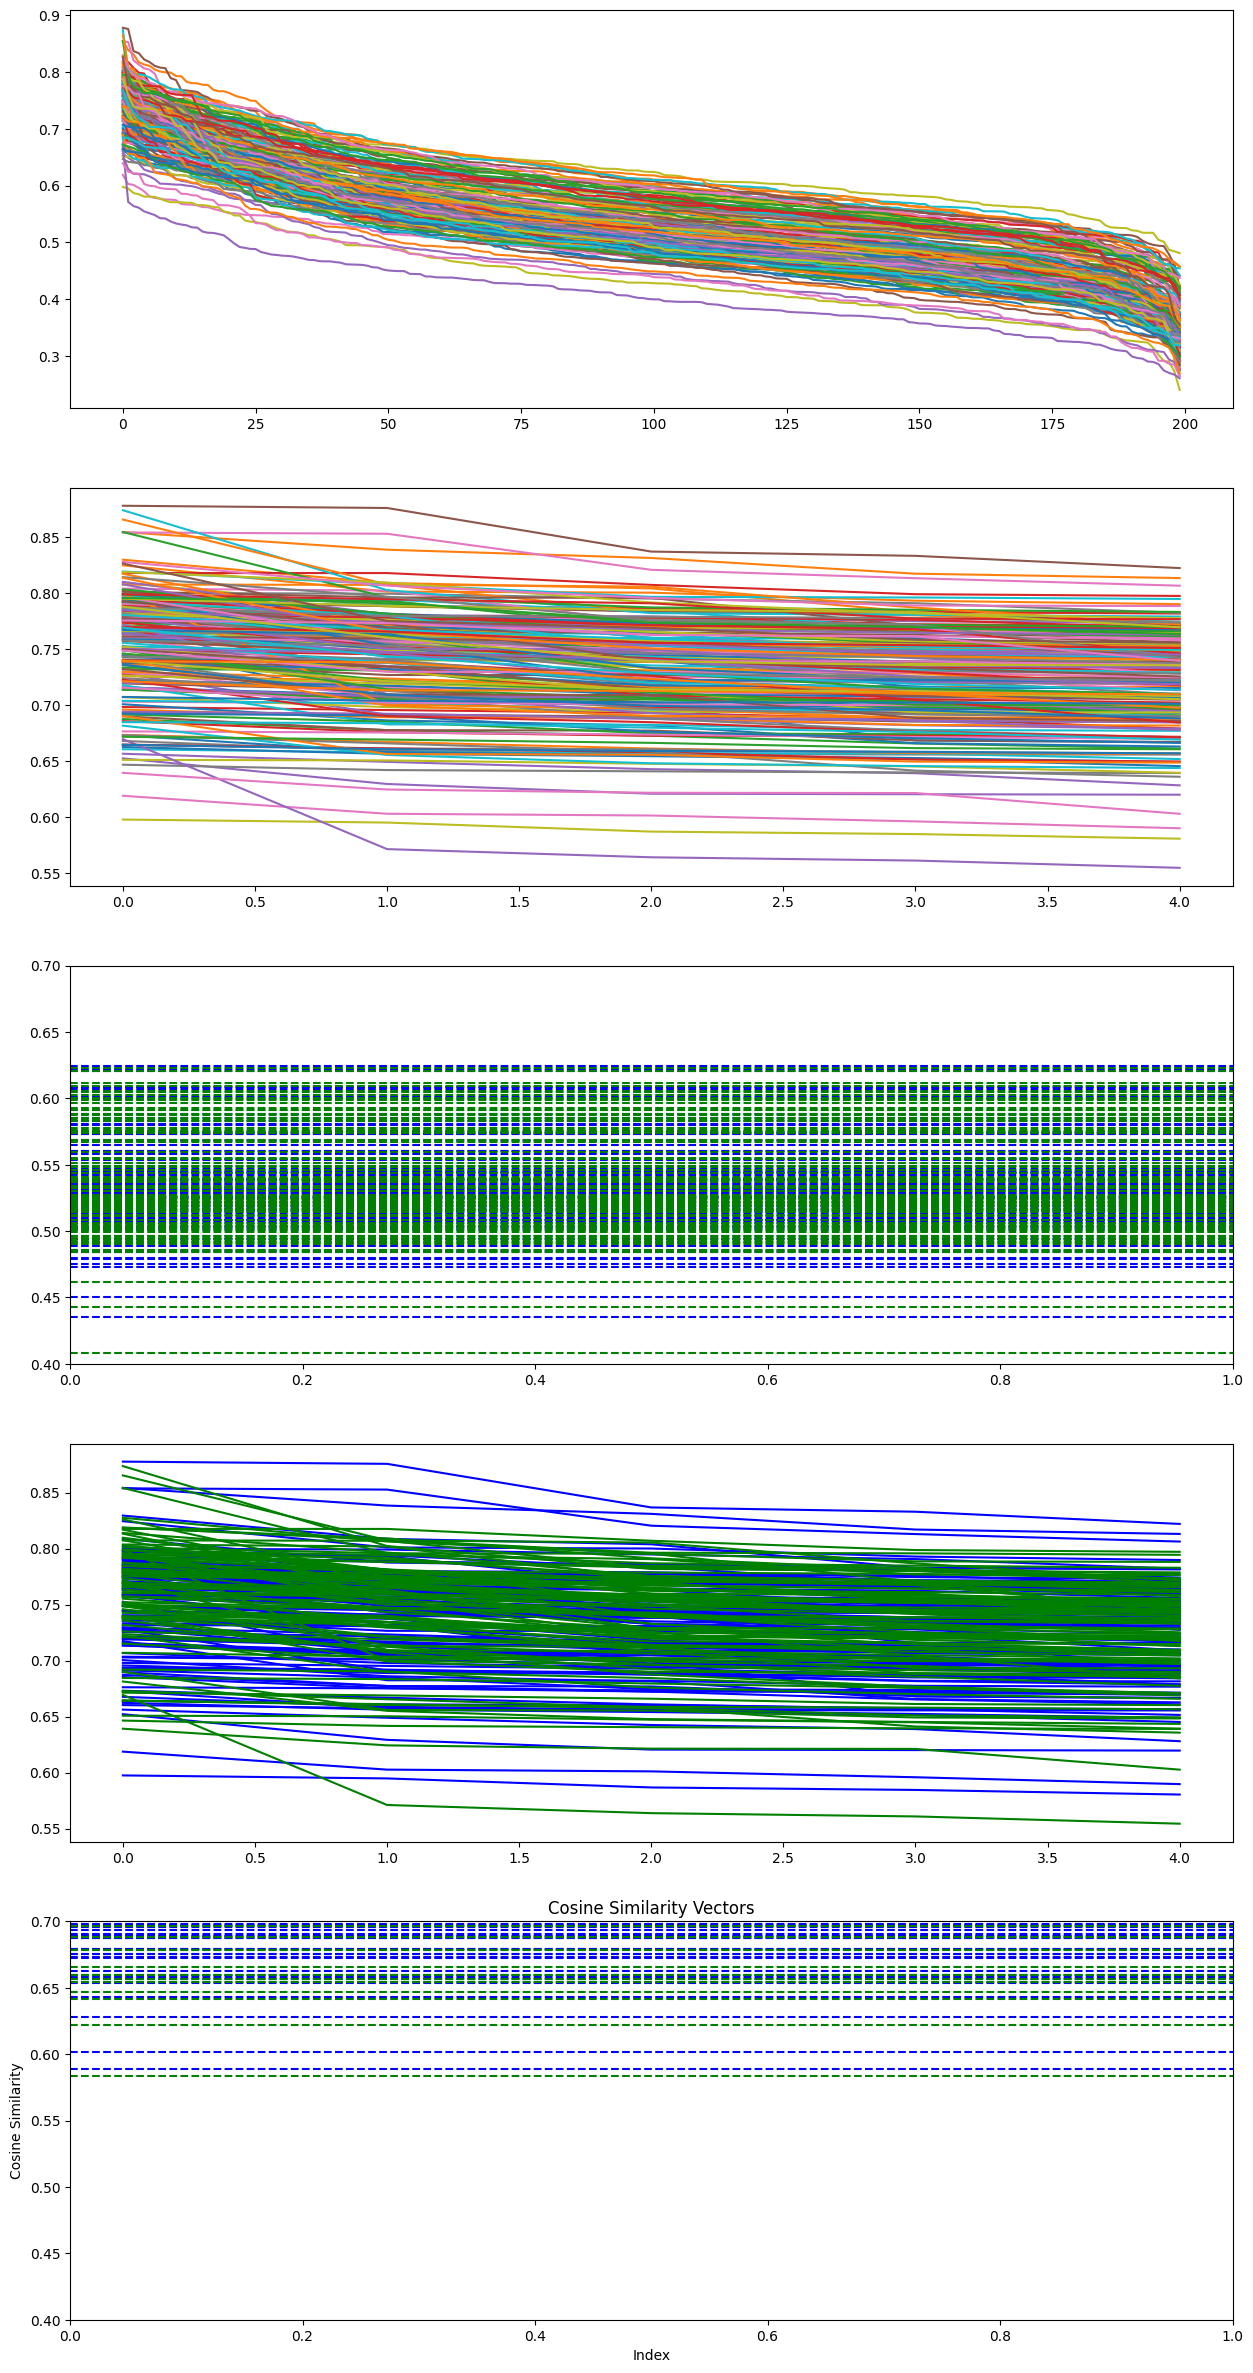

In [ ]:
import matplotlib.pyplot as plt

class_stats = load_json("class_analysis/json/class_analysis_cub.json")
print(class_stats["American Crow"]["cosine_similarity_vector"])

class_list = compute_class_list(class_stats, True)
# class_list = exceptional_classes

# Create a new figure
plt.figure(figsize=(15, 30))

# Create a vector of 10 different flags for line colour in a matplotlib plot
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# Loop through each class_name in class_stats
i = 0
for class_name in class_list:
    # colour = colours[i]

    if i < len(class_list) / 2:
        colour = colours[0]
    else:
        colour = colours[1]

    class_stats[class_name]["cosine_similarity_vector"] = sorted(class_stats[class_name]["cosine_similarity_vector"], key=abs, reverse=True)
    cosine_similarity_vector = class_stats[class_name]['cosine_similarity_vector']
    similarity_average = sum(cosine_similarity_vector) / len(cosine_similarity_vector)
    cosine_similarity_vector_top5 = cosine_similarity_vector[:5]
    similarity_average_top5 = sum(cosine_similarity_vector_top5) / len(cosine_similarity_vector_top5)
    plt.subplot(5, 1, 1)
    plt.plot(cosine_similarity_vector, label=class_name)
    plt.subplot(5, 1, 2)
    plt.plot(cosine_similarity_vector_top5, label=class_name + " Top 5")
    plt.subplot(5, 1, 3)
    plt.ylim(0.4, 0.7)
    plt.axhline(y=similarity_average, color=colour, linestyle='--', label='Average: ' + class_name)
    plt.subplot(5, 1, 4)
    plt.plot(cosine_similarity_vector_top5, color=colour, label=class_name)
    plt.subplot(5, 1, 5)
    plt.axhline(y=similarity_average_top5, color=colour, linestyle='--', label='Average: ' + class_name)
    plt.ylim(0.4, 0.7)
    i += 1

# Add title and labels
plt.title('Cosine Similarity Vectors')
plt.ylabel('Cosine Similarity')
plt.xlabel('Index')

# Add a legend
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, -0.05))

# Show the plot
plt.show()

## Create descriptor set using the top 5 results

- Rank the similarity between classes and descriptors
- Assign the 5 most similar descriptors with each class to that class
- Save the classes and descriptors in the same form as original dataset

In [ ]:
import numpy as np

class_stats = load_json("class_analysis/json/class_analysis_cub.json")
descriptors = load_json("descriptors/descriptors_cub.json")

class_list_reassignment = compute_class_list(class_stats, True)
descriptor_list_reassignment = compute_descriptor_list(descriptors, True)

descriptor_fitting = {}
for class_name in class_list:

    descriptor_fitting[class_name] = []

    cosine_similarity_vector = np.array(class_stats[class_name]["cosine_similarity_vector"])
    top_similarity_indices = np.argsort(cosine_similarity_vector)[-5:]

    for index in top_similarity_indices:
        print(class_name, descriptor_list_reassignment[index])
        descriptor_fitting[class_name].append(descriptor_list_reassignment[index])

descriptors_original = load_json("descriptors/descriptors_cub.json")

descriptors_new = {}
descriptors_new = {}

for key in descriptors_original.keys():
    key = key.replace("-"," ")
    descriptors_new[key] = key

    if key.replace("-"," ") in descriptor_fitting:
        descriptors_new[key.replace("-"," ")] = descriptor_fitting[key]

with open("descriptors/descriptors_cub_reassignment.json", 'w') as file:
    json.dump(descriptors_new, file, indent=4)


Acadian Flycatcher a black mark on its head
Acadian Flycatcher a black crest
Acadian Flycatcher a black head and bill
Acadian Flycatcher a long, curved bill
Acadian Flycatcher a light brown breast with dark streaks
American Crow a black stripe down the center of the back
American Crow a blackbird with a glossy black plumage
American Crow a black crest
American Crow a blue-grey back
American Crow a black head, neck, and chest with a white band around the neck
American Goldfinch a black head and bill
American Goldfinch a large, orange bill
American Goldfinch a long, curved bill
American Goldfinch a black crest
American Goldfinch a brown back with white streaks
American Pipit a black stripe down the center of the back
American Pipit a large, orange bill
American Pipit a black head, neck, and chest with a white band around the neck
American Pipit a long, curved bill
American Pipit a black mark on its head
American Redstart a long, curved bill
American Redstart a blue-grey back
American Red

## Create descriptor set using the top 5 results, with a similarity threshold

- Rank the similarity between classes and descriptors
- Define a similarity threshold using the distribution of the similarity data
- Assign the 5 most similar descriptors with each class to that class, with each new descriptor having similarity difference of at least the threshold value
- Save the classes and descriptors in the same form as original dataset

In [ ]:
import numpy as np


class_stats = load_json("class_analysis/json/class_analysis_cub.json")
descriptors = load_json("descriptors/descriptors_cub.json")

class_list_reassignment = compute_class_list(class_stats, True)
descriptor_list_reassignment = compute_descriptor_list(descriptors, True)

descriptor_fitting = {}
similarity_index_alteration_count_vector = []
for class_name in class_list:

    descriptor_fitting[class_name] = []

    cosine_similarity_vector = np.array(class_stats[class_name]["cosine_similarity_vector"])

    sorted_similarity_indices = np.argsort(cosine_similarity_vector)

    top_similarity_indices = [sorted_similarity_indices[-1]]

    # Set minimum similarity difference threshold based on bounds of cosine similarity vector spread
    similarity_difference_threshold = (max(class_stats[class_name]["cosine_similarity_vector"]) - min(class_stats[class_name]["cosine_similarity_vector"])) / 100
    i = 1
    while len(top_similarity_indices) < 5:
        if (cosine_similarity_vector[top_similarity_indices[-1]] - cosine_similarity_vector[sorted_similarity_indices[-i]]) > similarity_difference_threshold:
            top_similarity_indices.append(sorted_similarity_indices[-i])
        i += 1

    descriptor_fitting[class_name] = [descriptor_list_reassignment[index] for index in top_similarity_indices]
    
    similarity_index_alteration_count = 0
    for index in range(5):
        if top_similarity_indices[index] in sorted_similarity_indices[-5:]:
            similarity_index_alteration_count += 1

    similarity_index_alteration_count_vector.append(similarity_index_alteration_count)

print(sum(similarity_index_alteration_count_vector) / len(similarity_index_alteration_count_vector))

descriptors_original = load_json("descriptors/descriptors_cub.json")
descriptors_new = {}
for key in descriptors_original.keys():
    key = key.replace("-"," ")
    descriptors_new[key] = key
    if key.replace("-"," ") in descriptor_fitting:
        descriptors_new[key.replace("-"," ")] = descriptor_fitting[key]

with open("descriptors/descriptors_cub_reassignment_threshold.json", 'w') as file:
    json.dump(descriptors_new, file, indent=4)


3.555


## Visualisation of Exceptional Cases
Visualisation of exceptional cases, i.e. the top 5 and bottom 5 classes that are most responsive to the change from CLIP to D-CLIP, both positively and negatively.

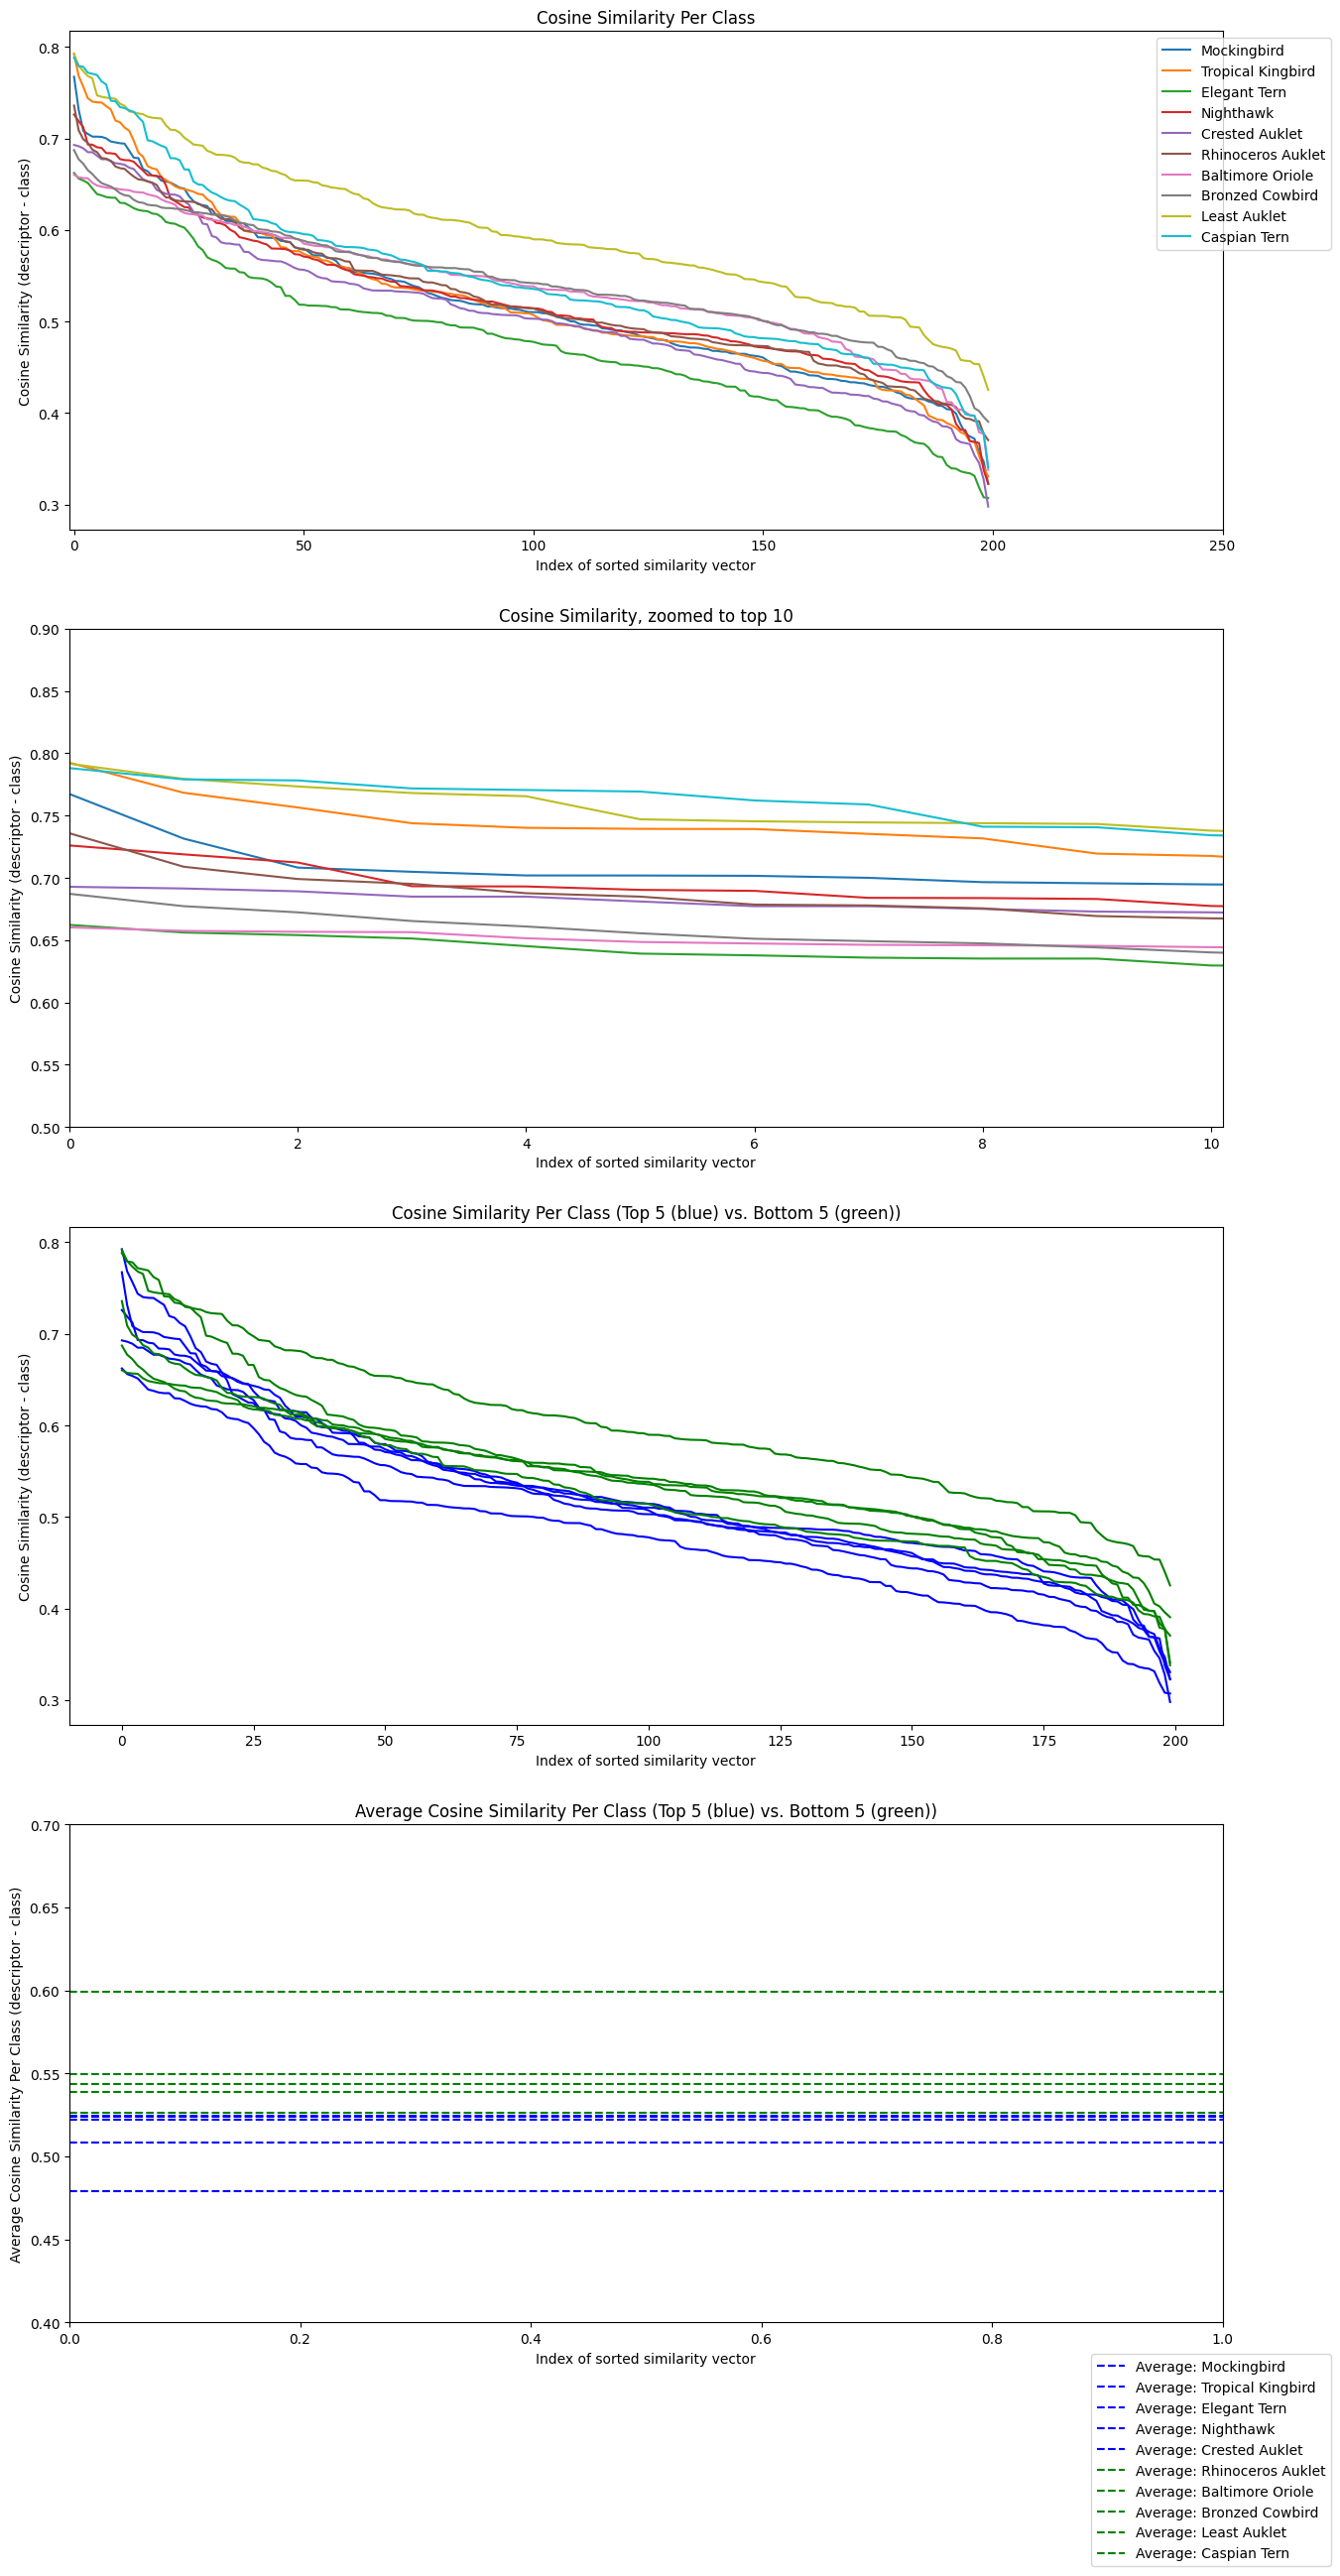

In [ ]:
import matplotlib.pyplot as plt

class_stats = load_json("class_analysis/json/class_analysis_cub.json")
exp_results = load_json("results/experiment_results.json")

class_list = compute_class_list(class_stats, True)
class_list = exceptional_classes

# Create a new figure
plt.figure(figsize=(15, 30))

# Create a vector of 10 different flags for line colour in a matplotlib plot
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# Loop through each class_name in class_stats
i = 0
dataset_fraction = 0.025
colour = colours[0]
for class_name in class_list:


    if i < 20:
        if i < len(class_list) / 2:
            colour = colours[0]
        else:
            colour = colours[1]
    # else:
    #     if i < len(class_list) * dataset_fraction:
    #         colour = colours[0]
    #     elif i > len(class_list) * (1 - dataset_fraction):
    #         colour = colours[1]
    #     else:
    #         # Remove entry from similarity_average and cosine_similarity_vector
    #         class_stats.pop(class_name)
    #         i += 1
    #         continue

    class_stats[class_name]["cosine_similarity_vector"] = sorted(class_stats[class_name]["cosine_similarity_vector"], key=abs, reverse=True)
    cosine_similarity_vector = class_stats[class_name]['cosine_similarity_vector']
    similarity_average = sum(cosine_similarity_vector) / len(cosine_similarity_vector)

    plt.subplot(4, 1, 1)
    plt.plot(cosine_similarity_vector, label=class_name)
    plt.title('Cosine Similarity Per Class')
    plt.ylabel('Cosine Similarity (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')
    plt.xlim(-1, 250)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.subplot(4, 1, 2)
    plt.plot(cosine_similarity_vector, label=class_name)
    plt.xlim(0,10.1)
    plt.ylim(0.5, 0.9)
    plt.title('Cosine Similarity, zoomed to top 10')
    plt.ylabel('Cosine Similarity (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')

    plt.subplot(4, 1, 3)
    plt.plot(cosine_similarity_vector, color=colour, label=class_name)
    plt.title('Cosine Similarity Per Class (Top 5 (blue) vs. Bottom 5 (green))')
    plt.ylabel('Cosine Similarity (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')

    plt.subplot(4, 1, 4)
    plt.ylim(0.4, 0.7)
    plt.axhline(y=similarity_average, linestyle='--', color=colour, label='Average: ' + class_name)
    plt.title('Average Cosine Similarity Per Class (Top 5 (blue) vs. Bottom 5 (green))')
    plt.ylabel('Average Cosine Similarity Per Class (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, -0.05))

    i += 1

# Add a legend


# Show the plot
plt.show()

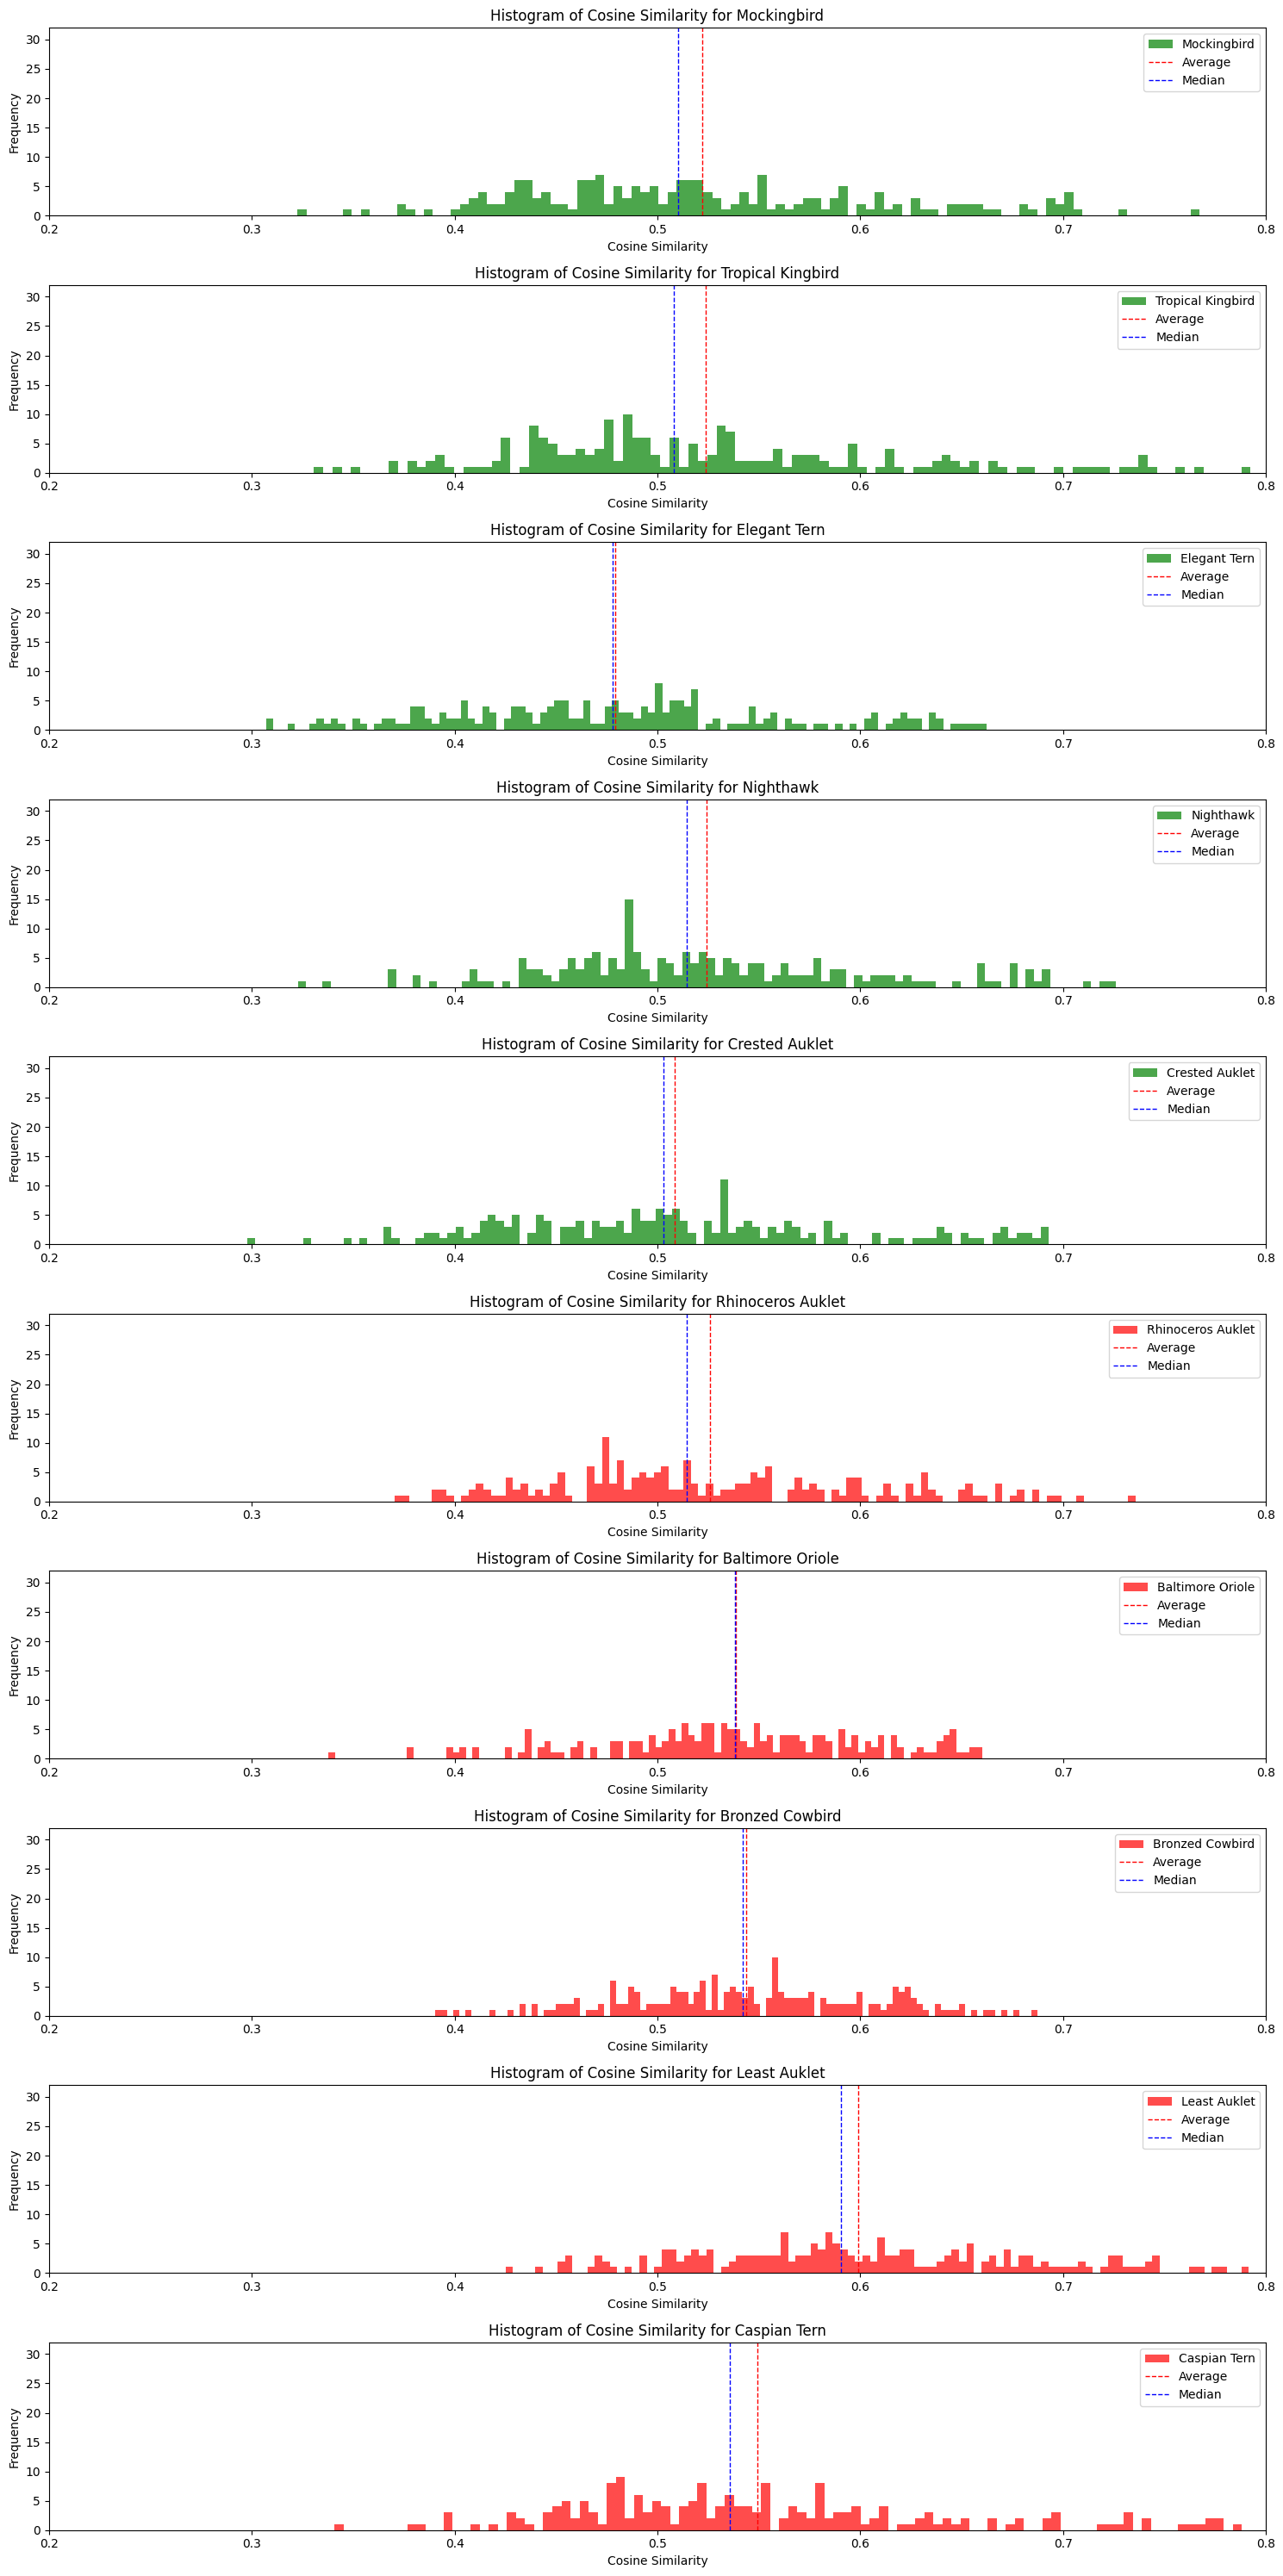

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming load_json and compute_class_list functions are defined elsewhere
class_stats = load_json("class_analysis/json/class_analysis_cub.json")
exp_results = load_json("results/experiment_results.json")

class_list = compute_class_list(class_stats, True)
class_list = exceptional_classes

# Create a new figure for histograms
plt.figure(figsize=(15, 30))

# Loop through each class_name in class_list and plot histogram
i = 0
for class_name in class_list:
    if i < len(class_list) / 2:
        color = 'g'
    else:
        color = 'r'
    cosine_similarity_vector = class_stats[class_name]["cosine_similarity_vector"]
    similarity_average = np.mean(cosine_similarity_vector)
    similarity_median = np.median(cosine_similarity_vector)
    
    plt.subplot(len(class_list), 1, i+1)
    plt.hist(cosine_similarity_vector, bins=100, alpha=0.7, color=color, label=class_name)
    plt.axvline(similarity_average, color='r', linestyle='--', linewidth=1, label='Average')
    plt.axvline(similarity_median, color='b', linestyle='--', linewidth=1, label='Median')
    
    plt.title(f'Histogram of Cosine Similarity for {class_name}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.xlim(0.2, 0.8)
    plt.ylim(0, 32)
    plt.legend()

    i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the histogram plot
plt.show()


## Create confusion matrices

#### Create class confusion matrix

In [ ]:
import tiktoken

def tokenise_strings(strings):
    tokeniser = tiktoken.get_encoding("cl100k_base")

    # Tokenise each string in the list
    tokenised_strings = [tokeniser.encode(string) for string in strings]

    return tokenised_strings

def detokenise_tokens(tokenised_strings):
    tokeniser = tiktoken.get_encoding("cl100k_base")

    detokenised_strings = [tokeniser.decode(tokens) for tokens in tokenised_strings]

    return detokenised_strings


In [ ]:
import numpy as np
import pandas as pd

from loading_helpers import load_json
from load import compute_class_list

class_data = load_json('class_analysis/json/class_self_similarity_cub.json')

class_list = compute_class_list(class_data, True)
tokenised_class_list = tokenise_strings(class_list)
tokenised_class_list = [str(token_list) for token_list in tokenised_class_list]
blended_class_list = [ class_list[i] + " - " + tokenised_class_list[i] for i in range(len(class_list))]

class_confusion_matrix = np.zeros((len(class_list), len(class_list)))
tokenised_class_confusion_matrix = np.zeros((len(tokenised_class_list), len(tokenised_class_list)))
blended_class_confusion_matrix = np.zeros((len(blended_class_list), len(blended_class_list)))

for i, class_name in enumerate(class_list):
    class_confusion_matrix[i, :] = class_data[class_name]['cosine_similarity_vector']
    tokenised_class_confusion_matrix[i, :] = class_data[class_name]['cosine_similarity_vector']
    blended_class_confusion_matrix[i, :] = class_data[class_name]['cosine_similarity_vector']

class_confusion_matrix_df = pd.DataFrame(class_confusion_matrix, index=class_list, columns=class_list)
tokenised_class_confusion_matrix_df = pd.DataFrame(tokenised_class_confusion_matrix, index=tokenised_class_list, columns=tokenised_class_list)
blended_class_confusion_matrix_df = pd.DataFrame(blended_class_confusion_matrix, index=blended_class_list, columns=blended_class_list)

print(tokenised_class_confusion_matrix_df)

                                            [11916, 10272, 20793, 7320, 261]  \
[11916, 10272, 20793, 7320, 261]                                    1.000000   
[29518, 27991]                                                      0.668457   
[29518, 7573, 5589, 331]                                            0.724609   
[29518, 78482, 275]                                                 0.756836   
[29518, 3816, 2527]                                                 0.730469   
...                                                                      ...   
[48799, 1481, 616, 1142, 20793, 7320, 261]                          0.866211   
[48799, 1481, 4473, 356, 1983, 2689]                                0.647949   
[48799, 93008, 15386, 13149]                                        0.681152   
[48799, 62166, 5348, 23414]                                         0.596680   
[48799, 7716, 299, 660, 650, 556, 78]                               0.798828   

                                       

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 20))
sns.heatmap(blended_class_confusion_matrix_df, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Cosine Similarity Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

### Hierarchical Clustering with Seaborn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the clustered heatmap
plt.figure(figsize=(100, 100))
sns.clustermap(class_confusion_matrix_df, cmap='coolwarm', figsize=(100, 100))
plt.title('Hierarchical Clustered Cosine Similarity Confusion Matrix')
plt.show()


### Interactive Heatmap with Plotly

In [ ]:
import plotly.express as px

size = 4000  # 4000 in practice

tokenisation = True
blended = True

if tokenisation:
    class_list = tokenised_class_list
    class_confusion_matrix_df = tokenised_class_confusion_matrix_df

if blended:
    class_list = blended_class_list
    class_confusion_matrix_df = blended_class_confusion_matrix_df

# Plot the interactive heatmap
fig = px.imshow(class_confusion_matrix_df,
                labels = {
                    'x': '',
                    'y': '',
                    'color': 'Cosine Similarity'},
                x=class_list,
                y=class_list,
                color_continuous_scale='RdBu_r',
                width = size,
                height = size)
fig.update_layout(title='Interactive Cosine Similarity Confusion Matrix')
fig.show()

['1. Worm-eating Warbler - [54, 494, 5773, 1113, 5111, 78562]', '2. Bay-breasted Warbler - [23407, 93008, 15386, 5111, 78562]', '3. Least Flycatcher - [82916, 20793, 7320, 261]', '4. Mourning Warbler - [44, 414, 1251, 5111, 78562]', '5. Spotted Catbird - [6540, 15889, 17810, 23414]', '6. Tennessee Warbler - [51, 22181, 5111, 78562]', '7. Black-capped Vireo - [14755, 1824, 5795, 650, 556, 78]', '8. Warbling Vireo - [29784, 9894, 650, 556, 78]', '9. Nelson-Sharp-tailed Sparrow - [45, 22110, 12, 25023, 2442, 5805, 70906, 654]', '10. Acadian Flycatcher - [11916, 10272, 20793, 7320, 261]', '11. Yellow-bellied Flycatcher - [48799, 1481, 616, 1142, 20793, 7320, 261]', '12. Great-Crested Flycatcher - [22111, 7813, 4014, 291, 20793, 7320, 261]', '13. Yellow-throated Vireo - [48799, 7716, 299, 660, 650, 556, 78]', '14. House Sparrow - [29707, 70906, 654]', '15. Baird Sparrow - [33, 1334, 67, 70906, 654]', '16. Seaside Sparrow - [1542, 29612, 70906, 654]', '17. Olive-sided Flycatcher - [46, 25859

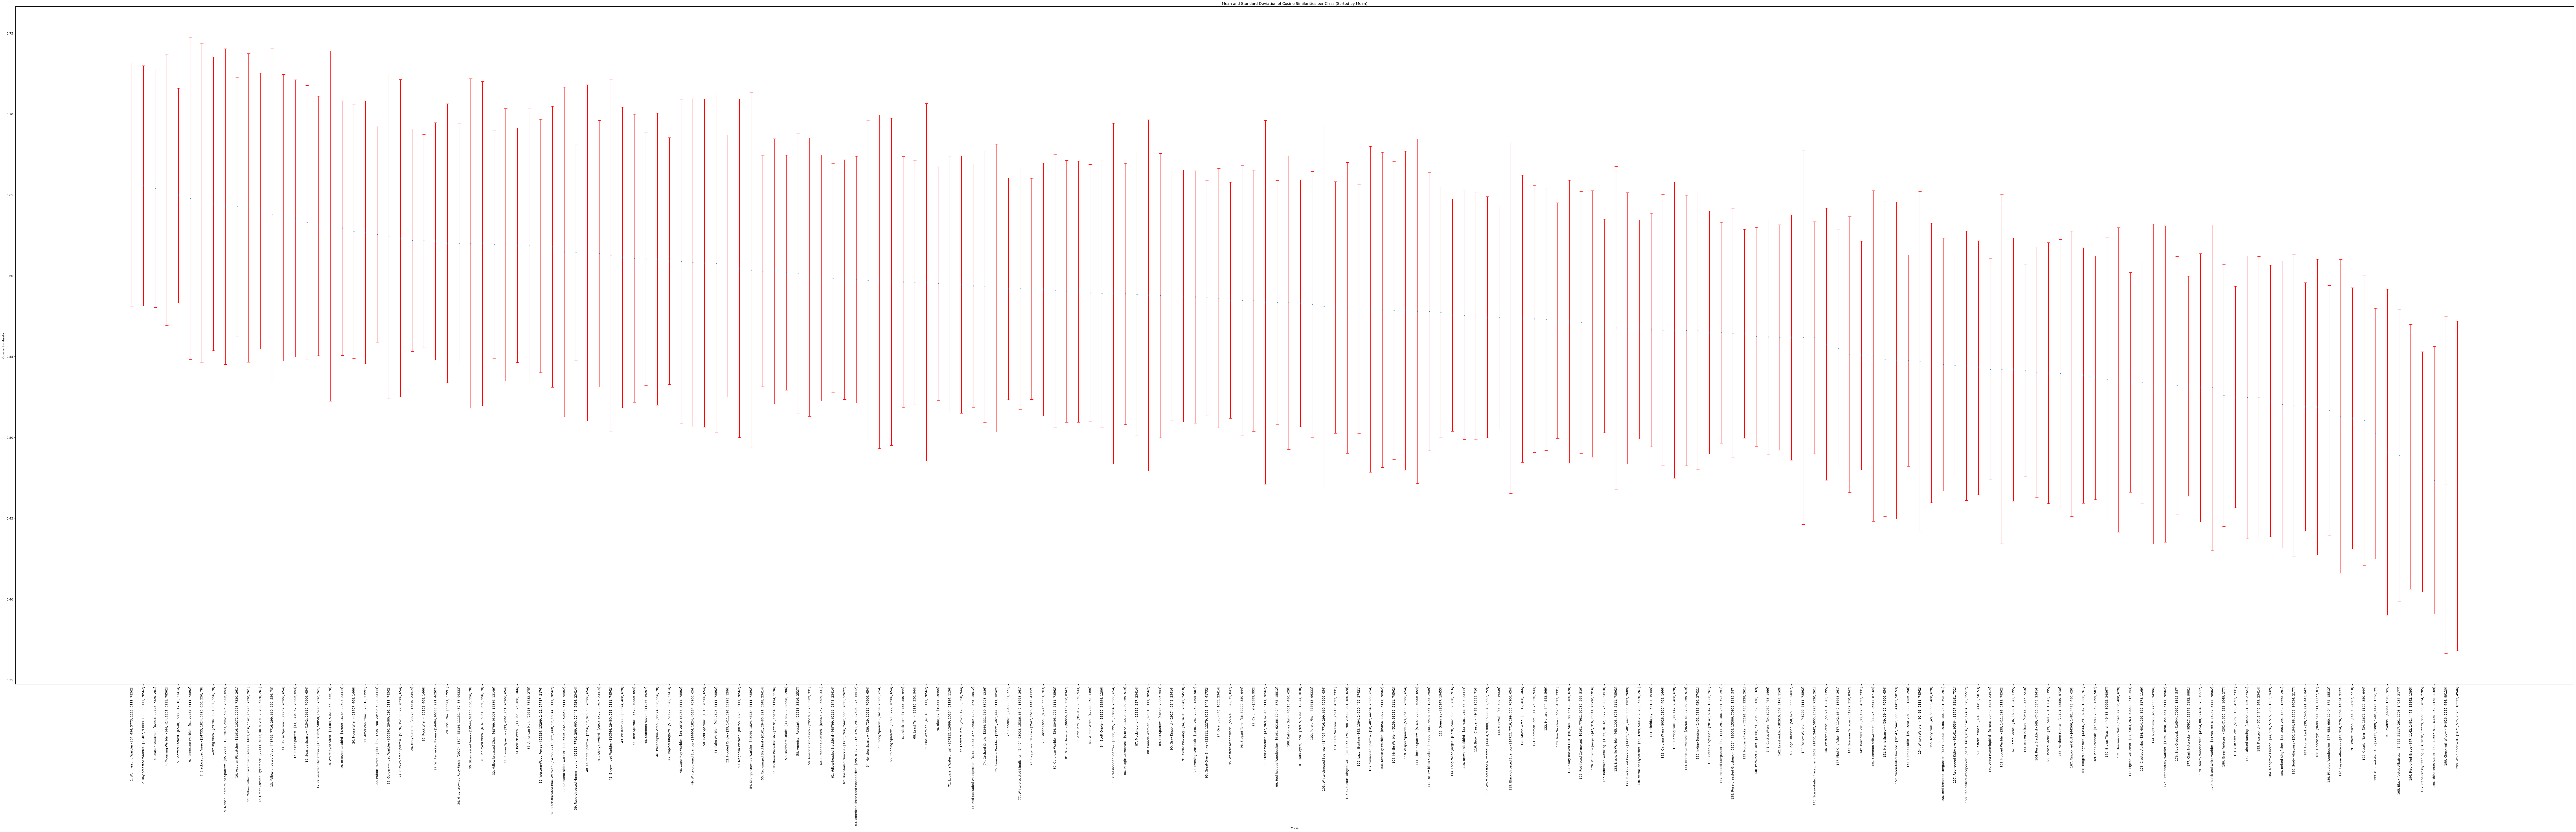

In [ ]:
import matplotlib.pyplot as plt

# Calculate summary statistics
mean_similarities = class_confusion_matrix_df.mean(axis=1)
std_similarities = class_confusion_matrix_df.std(axis=1)

# Combine mean and std into a single DataFrame for easier sorting
summary_df = class_confusion_matrix_df.copy()
summary_df['mean'] = mean_similarities
summary_df['std'] = std_similarities

# Sort by mean in descending order
summary_df_sorted_by_mean = summary_df.sort_values(by='mean', ascending=False)

# Extract sorted means and stds
sorted_means_by_mean = summary_df_sorted_by_mean['mean']
sorted_stds_by_mean = summary_df_sorted_by_mean['std']
sorted_classes_by_mean = summary_df_sorted_by_mean.index

numbered_sorted_classes_by_mean = []
i = 0
for index in sorted_classes_by_mean.values:
    numbered_sorted_classes_by_mean.append(str(i+1) + ". " + index)
    i += 1

print(numbered_sorted_classes_by_mean)

# Plot summary statistics sorted by mean
plt.figure(figsize=(150, 40))
plt.errorbar(numbered_sorted_classes_by_mean, sorted_means_by_mean, yerr=sorted_stds_by_mean, fmt='o', ecolor='r', capsize=5, markersize=2)
plt.title('Mean and Standard Deviation of Cosine Similarities per Class (Sorted by Mean)')
plt.xlabel('Class')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=90)
plt.show()

['1. Yellow Warbler - [48799, 5111, 78562]', '2. White-throated Sparrow - [14404, 7716, 299, 660, 70906, 654]', '3. Prairie Warbler - [47, 969, 62316, 5111, 78562]', '4. Pine Warbler - [47, 483, 5111, 78562]', '5. Orange-crowned Warbler - [43069, 1824, 45184, 5111, 78562]', '6. Blue-winged Warbler - [10544, 29480, 291, 5111, 78562]', '7. Canada Warbler - [37031, 5111, 78562]', '8. Black-throated Sparrow - [14755, 7716, 299, 660, 70906, 654]', '9. White-eyed Vireo - [14404, 53613, 650, 556, 78]', '10. Hooded Warbler - [39, 1411, 291, 5111, 78562]', '11. Lincoln Sparrow - [51697, 22808, 70906, 654]', '12. Grasshopper Sparrow - [6600, 395, 71, 18994, 70906, 654]', '13. Wilson Warbler - [92493, 5111, 78562]', '14. Magnolia Warbler - [88755, 39260, 5111, 78562]', '15. Palm Warbler - [47, 7828, 5111, 78562]', '16. Chuck-will Widow - [94626, 2695, 484, 89120]', '17. Le-Conte Sparrow - [2356, 12, 825, 68, 70906, 654]', '18. Song Sparrow - [34139, 70906, 654]', '19. Yellow-throated Vireo - [487

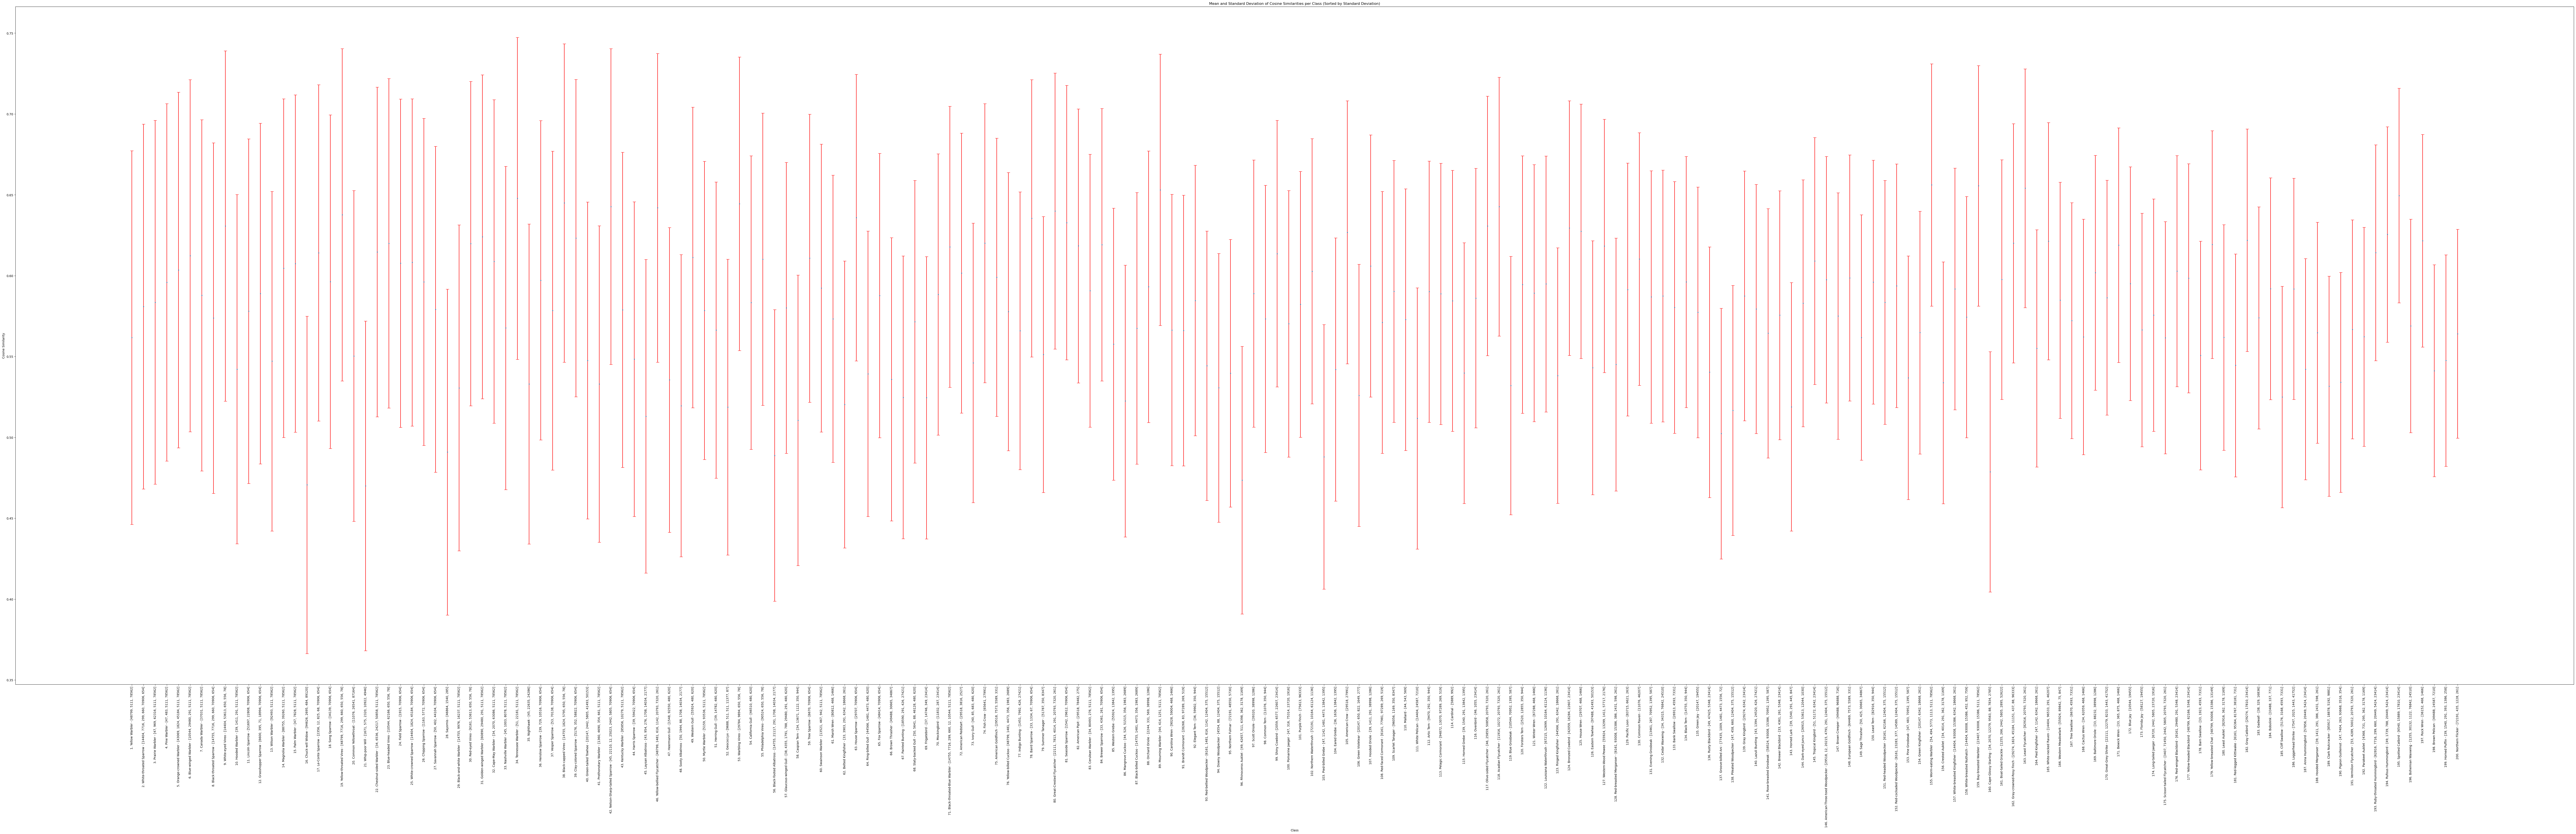

In [ ]:
import matplotlib.pyplot as plt

# Calculate summary statistics
mean_similarities = class_confusion_matrix_df.mean(axis=1)
std_similarities = class_confusion_matrix_df.std(axis=1)

# print(class_confusion_matrix_df)

# Combine mean and std into a single DataFrame for easier sorting
summary_df = class_confusion_matrix_df.copy()
summary_df['mean'] = mean_similarities
summary_df['std'] = std_similarities

# Sort by standard deviation in descending order
summary_df_sorted_by_std = summary_df.sort_values(by='std', ascending=False)

# Extract sorted means and stds
sorted_means_by_std = summary_df_sorted_by_std['mean']
sorted_stds_by_std = summary_df_sorted_by_std['std']
sorted_classes_by_std = summary_df_sorted_by_std.index

numbered_sorted_classes_by_std = []
i = 0
for index in sorted_classes_by_std.values:
    numbered_sorted_classes_by_std.append(str(i+1) + ". " + index)
    i += 1

print(numbered_sorted_classes_by_std)


# Plot summary statistics sorted by standard deviation
plt.figure(figsize=(150, 40))
plt.errorbar(numbered_sorted_classes_by_std, sorted_means_by_std, yerr=sorted_stds_by_std, fmt='o', ecolor='r', capsize=5, markersize=2)
plt.title('Mean and Standard Deviation of Cosine Similarities per Class (Sorted by Standard Deviation)')
plt.xlabel('Class')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=90)
plt.show()